Imports.

/var/folders/g2/lznkhwyd1430dy2980sq86ch0000gn/T/ipykernel_56466/1272204706.py:193: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
/var/folders/g2/lznkhwyd1430dy2980sq86ch0000gn/T/ipykernel_56466/1272204706.py:210: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(change_data, labels=change_labels, patch_artist=True)
/var/folders/g2/lznkhwyd1430dy2980sq86ch0000gn/T/ipykernel_56466/1272204706.py:193: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
/var/folders/g2/lznkhwyd1430dy2980sq86ch0000gn/T/


=== Matching Results ===
Original treated patients: 266
Original untreated patients: 134
Matched pairs: 134

=== Covariate Balance ===
             Variable  Before_Mean_Diff  Before_Std_Diff  After_Mean_Diff  \
0       baseline_pain         -0.160812        -0.116319         0.037313   
1    baseline_urgency         -0.239535        -0.148038         0.037313   
2  baseline_frequency         -0.034059        -0.021160         0.022388   

   After_Std_Diff  Improvement  
0        0.027316     0.089003  
1        0.024246     0.123792  
2        0.014334     0.006826  

=== Wilcoxon Signed-Rank Test Result ===
Test statistic: 52.0
p-value: 3.141739272967875e-23
Conclusion: Significant difference in outcomes between matched treated and untreated groups

=== Regression Analysis ===
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.784
Model:                            OLS   Adj. R-squ

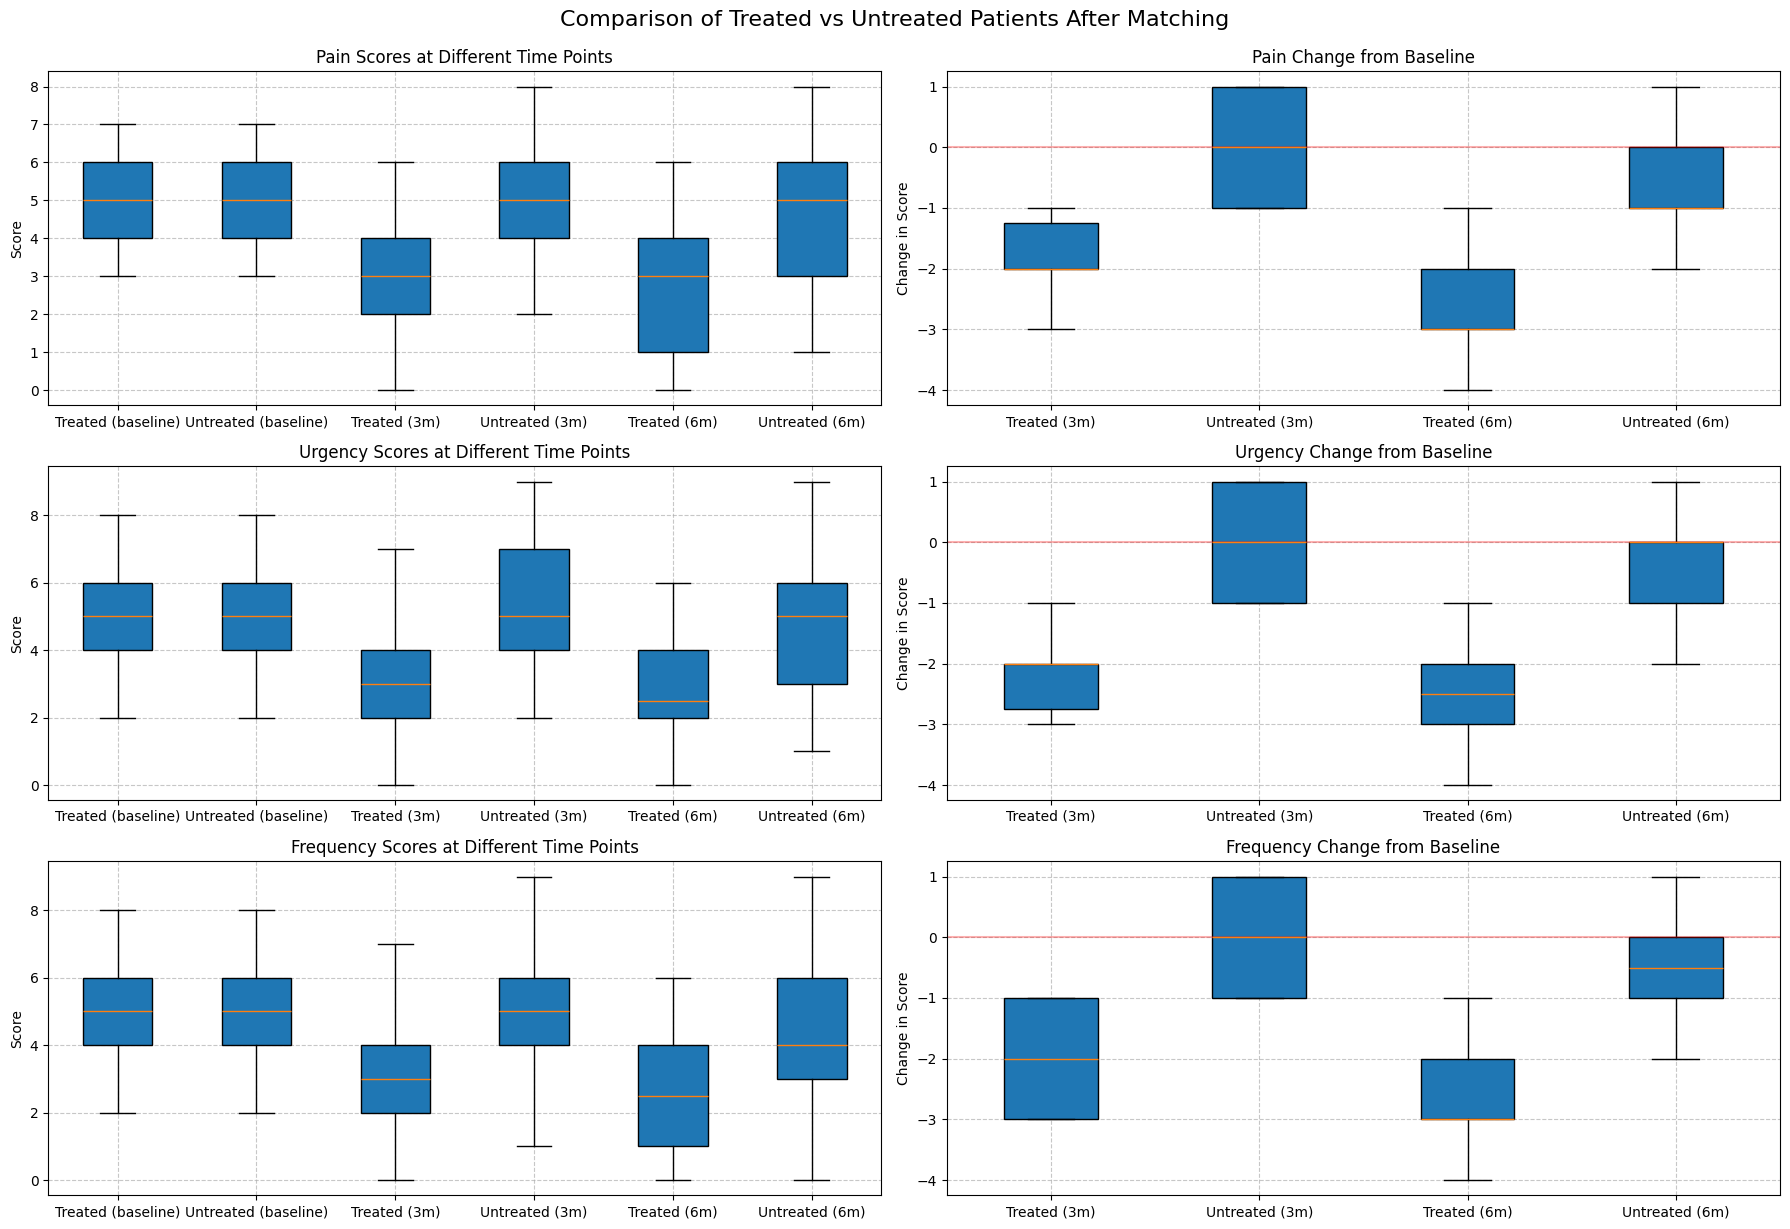

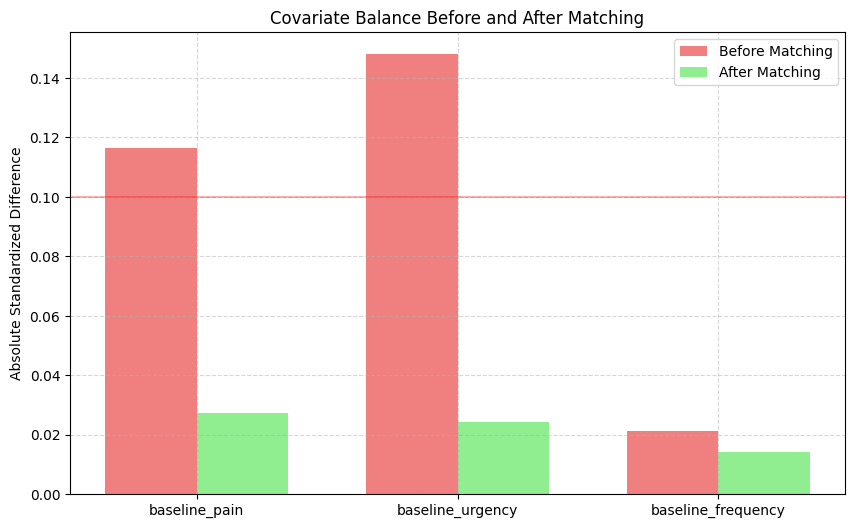

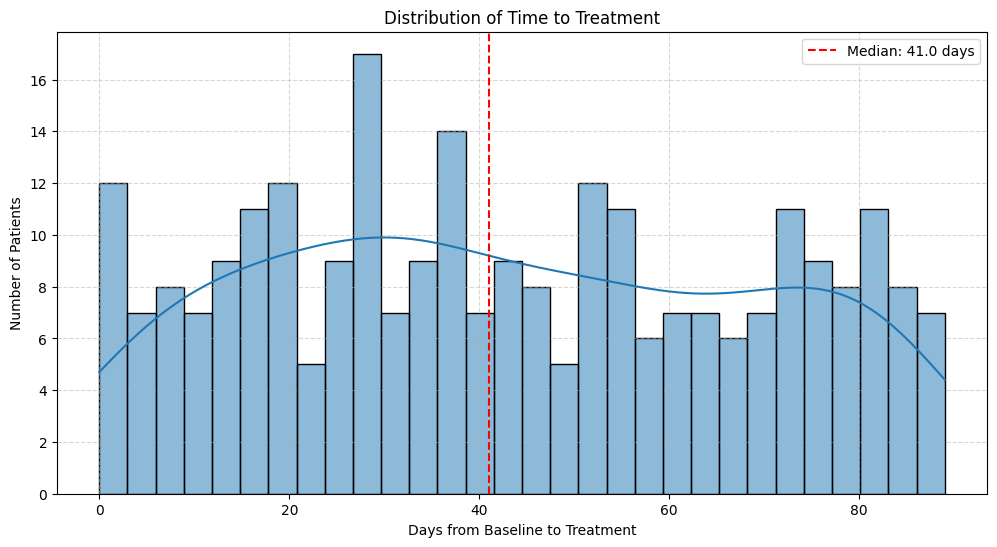

In [19]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis, cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

# Set random seed for reproducibility
np.random.seed(42)

# 1. Generate more realistic synthetic data
def generate_synthetic_data(n_patients=400):
    # Baseline date range
    start_date = datetime(2020, 1, 1)
    end_date = datetime(2020, 12, 31)
    date_range = (end_date - start_date).days
    
    data = []
    
    for i in range(n_patients):
        # Patient characteristics
        gender = np.random.choice(['M', 'F'])
        age = np.random.randint(30, 80)
        
        # Baseline measurements (with some correlation)
        base_pain = np.random.randint(3, 8)
        base_urgency = base_pain + np.random.randint(-1, 2)
        base_frequency = base_pain + np.random.randint(-1, 2)
        
        # Enrollment date
        days_offset = np.random.randint(0, date_range)
        baseline_date = start_date + timedelta(days=days_offset)
        
        # Decide if patient gets treatment (70% probability)
        gets_treatment = np.random.random() <0.7
        
        if gets_treatment:
            # Treatment occurs 0-90 days after baseline
            treatment_delay = np.random.randint(0, 90)
            treatment_date = baseline_date + timedelta(days=treatment_delay)
            treatment_time = treatment_delay
            
            # Treatment measurements (slight improvement from baseline)
            tx_pain = max(0, base_pain - np.random.randint(0, 2))
            tx_urgency = max(0, base_urgency - np.random.randint(0, 2))
            tx_frequency = max(0, base_frequency - np.random.randint(0, 2))
            
            # 3-month follow-up (treatment effect)
            pain_3m = max(0, tx_pain - np.random.randint(1, 3))
            urgency_3m = max(0, tx_urgency - np.random.randint(1, 3))
            frequency_3m = max(0, tx_frequency - np.random.randint(1, 3))
            
            # 6-month follow-up (further improvement)
            pain_6m = max(0, pain_3m - np.random.randint(0, 2))
            urgency_6m = max(0, urgency_3m - np.random.randint(0, 2))
            frequency_6m = max(0, frequency_3m - np.random.randint(0, 2))
            
            # Outcome (inversely related to symptoms)
            outcome = 10 - (pain_6m + urgency_6m + frequency_6m) / 3 + np.random.normal(0, 1)
            
        else:
            treatment_time = np.nan
            treatment_date = None
            
            # No treatment, so measurements stay roughly the same with natural variation
            tx_pain = np.nan
            tx_urgency = np.nan
            tx_frequency = np.nan
            
            # Natural course without treatment (slight random changes)
            pain_3m = base_pain + np.random.randint(-1, 2)
            urgency_3m = base_urgency + np.random.randint(-1, 2)
            frequency_3m = base_frequency + np.random.randint(-1, 2)
            
            pain_6m = pain_3m + np.random.randint(-1, 1)
            urgency_6m = urgency_3m + np.random.randint(-1, 1)
            frequency_6m = frequency_3m + np.random.randint(-1, 1)
            
            # Outcome for untreated (generally worse than treated)
            outcome = 10 - (pain_6m + urgency_6m + frequency_6m) / 3 + np.random.normal(-1, 1)
        
        # Combine all data
        patient_data = {
            'patient_id': i,
            'gender': gender,
            'age': age,
            'baseline_date': baseline_date,
            'treatment_time': treatment_time,
            'treatment_date': treatment_date,
            'baseline_pain': base_pain,
            'baseline_urgency': base_urgency,
            'baseline_frequency': base_frequency,
            'tx_pain': tx_pain,
            'tx_urgency': tx_urgency,
            'tx_frequency': tx_frequency,
            'pain_3m': pain_3m,
            'urgency_3m': urgency_3m,
            'frequency_3m': frequency_3m,
            'pain_6m': pain_6m,
            'urgency_6m': urgency_6m,
            'frequency_6m': frequency_6m,
            'outcome': outcome
        }
        
        data.append(patient_data)
    
    return pd.DataFrame(data)

# Generate data
df = generate_synthetic_data(n_patients=400)

# 2. Split into treated and untreated
treated = df.dropna(subset=['treatment_time']).copy()
not_treated = df[df['treatment_time'].isna()].copy()

# 3. Define covariates for matching
cov_cols = ['baseline_pain', 'baseline_urgency', 'baseline_frequency']

# 4. Compute Mahalanobis distance with risk-set matching
def calculate_mahalanobis_distances(treated_df, untreated_df, covariates):
    # Get covariates
    X_treated = treated_df[covariates].values
    X_untreated = untreated_df[covariates].values
    
    # Calculate covariance matrix from all patients
    X_all = df[covariates].values
    VI = np.linalg.inv(np.cov(X_all, rowvar=False))
    
    # Calculate Mahalanobis distances between each treated and untreated patient
    distances = cdist(X_treated, X_untreated, metric='mahalanobis', VI=VI)
    
    return distances

# Get distances
distances = calculate_mahalanobis_distances(treated, not_treated, cov_cols)

# 5. Perform optimal matching using Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(distances)

# 6. Create matched datasets
matched_treated = treated.iloc[row_ind].reset_index(drop=True)
matched_not_treated = not_treated.iloc[col_ind].reset_index(drop=True)

# 7. Calculate differences for matched pairs
def calculate_differences(matched_treated, matched_not_treated):
    # Create copies to avoid modifying original data
    t_df = matched_treated.copy()
    nt_df = matched_not_treated.copy()
    
    # Calculate changes from baseline for both groups
    for time in ['3m', '6m']:
        for measure in ['pain', 'urgency', 'frequency']:
            col = f'{measure}_{time}'
            base_col = f'baseline_{measure}'
            
            # Change from baseline
            t_df[f'{col}_change'] = t_df[col] - t_df[base_col]
            nt_df[f'{col}_change'] = nt_df[col] - nt_df[base_col]
    
    return t_df, nt_df

matched_treated, matched_not_treated = calculate_differences(matched_treated, matched_not_treated)

# 8. Boxplot visualization function
def plot_combined_boxplots(matched_treated, matched_not_treated):
    measures = ['pain', 'urgency', 'frequency']
    times = ['baseline', '3m', '6m']
    
    # Create a figure with subplots
    fig, axes = plt.subplots(len(measures), 2, figsize=(18, 12))
    
    for i, measure in enumerate(measures):
        # Raw scores plot
        ax1 = axes[i, 0]
        data_to_plot = []
        labels = []
        
        for time in times:
            if time == 'baseline':
                col = f'{time}_{measure}'
            else:
                col = f'{measure}_{time}'
            
            if col in matched_treated.columns and col in matched_not_treated.columns:
                data_to_plot.append(matched_treated[col])
                data_to_plot.append(matched_not_treated[col])
                labels.extend([f'Treated ({time})', f'Untreated ({time})'])
        
        ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
        ax1.set_title(f'{measure.capitalize()} Scores at Different Time Points')
        ax1.set_ylabel('Score')
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Change from baseline plot
        ax2 = axes[i, 1]
        change_data = []
        change_labels = []
        
        for time in ['3m', '6m']:
            col = f'{measure}_{time}_change'
            if col in matched_treated.columns and col in matched_not_treated.columns:
                change_data.append(matched_treated[col])
                change_data.append(matched_not_treated[col])
                change_labels.extend([f'Treated ({time})', f'Untreated ({time})'])
        
        ax2.boxplot(change_data, labels=change_labels, patch_artist=True)
        ax2.set_title(f'{measure.capitalize()} Change from Baseline')
        ax2.set_ylabel('Change in Score')
        ax2.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.suptitle('Comparison of Treated vs Untreated Patients After Matching', y=1.02, fontsize=16)
    return fig

# Generate plot
boxplot_fig = plot_combined_boxplots(matched_treated, matched_not_treated)

# 9. Wilcoxon Signed-Rank Test for outcome
wilcoxon_result = wilcoxon(matched_treated['outcome'], matched_not_treated['outcome'])

# 10. Additional Analyses:

# a. Check covariate balance before and after matching
def check_covariate_balance(original_treated, original_untreated, matched_treated, matched_untreated, covariates):
    results = []
    
    for var in covariates:
        # Before matching
        before_diff = original_treated[var].mean() - original_untreated[var].mean()
        before_std = np.sqrt((original_treated[var].var() + original_untreated[var].var()) / 2)
        before_std_diff = before_diff / before_std if before_std != 0 else np.nan
        
        # After matching
        after_diff = matched_treated[var].mean() - matched_untreated[var].mean()
        after_std = np.sqrt((matched_treated[var].var() + matched_untreated[var].var()) / 2)
        after_std_diff = after_diff / after_std if after_std != 0 else np.nan
        
        results.append({
            'Variable': var,
            'Before_Mean_Diff': before_diff,
            'Before_Std_Diff': before_std_diff,
            'After_Mean_Diff': after_diff,
            'After_Std_Diff': after_std_diff,
            'Improvement': abs(before_std_diff) - abs(after_std_diff)
        })
    
    return pd.DataFrame(results)

balance_results = check_covariate_balance(treated, not_treated, matched_treated, matched_not_treated, cov_cols)

# b. Visualize covariate balance
def plot_covariate_balance(balance_df):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    variables = balance_df['Variable']
    before = balance_df['Before_Std_Diff']
    after = balance_df['After_Std_Diff']
    
    x = np.arange(len(variables))
    width = 0.35
    
    ax.bar(x - width/2, before.abs(), width, label='Before Matching', color='lightcoral')
    ax.bar(x + width/2, after.abs(), width, label='After Matching', color='lightgreen')
    
    ax.set_ylabel('Absolute Standardized Difference')
    ax.set_title('Covariate Balance Before and After Matching')
    ax.set_xticks(x)
    ax.set_xticklabels(variables)
    ax.legend()
    ax.axhline(y=0.1, color='r', linestyle='-', alpha=0.3, label='Threshold (0.1)')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    return fig

balance_plot = plot_covariate_balance(balance_results)

# c. Time-To-Event Analysis (for treatment timing)
def plot_treatment_timing_distribution(treated_df):
    plt.figure(figsize=(12, 6))
    
    # Create a histogram of treatment times
    sns.histplot(treated_df['treatment_time'].dropna(), bins=30, kde=True)
    plt.title('Distribution of Time to Treatment')
    plt.xlabel('Days from Baseline to Treatment')
    plt.ylabel('Number of Patients')
    plt.axvline(treated_df['treatment_time'].median(), color='r', linestyle='--', 
                label=f'Median: {treated_df["treatment_time"].median():.1f} days')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    return plt.gcf()

timing_plot = plot_treatment_timing_distribution(treated)

# d. Outcome analysis with regression adjustment
def analyze_outcomes_with_regression(treated_df, untreated_df):
    # Combine datasets and create treatment indicator
    treated_df = treated_df.copy()
    untreated_df = untreated_df.copy()
    
    treated_df['treated'] = 1
    untreated_df['treated'] = 0
    
    combined = pd.concat([treated_df, untreated_df])
    
    # Variables for regression
    X = combined[['treated', 'age', 'baseline_pain', 'baseline_urgency', 'baseline_frequency']]
    X = sm.add_constant(X)
    y = combined['outcome']
    
    # Fit regression model
    model = sm.OLS(y, X).fit()
    
    return model

regression_model = analyze_outcomes_with_regression(matched_treated, matched_not_treated)

# 11. Print Results
print("\n=== Matching Results ===")
print(f"Original treated patients: {len(treated)}")
print(f"Original untreated patients: {len(not_treated)}")
print(f"Matched pairs: {len(matched_treated)}")

print("\n=== Covariate Balance ===")
print(balance_results)

print("\n=== Wilcoxon Signed-Rank Test Result ===")
print(f"Test statistic: {wilcoxon_result.statistic}")
print(f"p-value: {wilcoxon_result.pvalue}")
if wilcoxon_result.pvalue <0.05:
    print("Conclusion: Significant difference in outcomes between matched treated and untreated groups")
else:
    print("Conclusion: No significant difference in outcomes between matched treated and untreated groups")

print("\n=== Regression Analysis ===")
print(regression_model.summary())

# 12. Save all visualizations
boxplot_fig.savefig('matched_boxplots.png', bbox_inches='tight')
balance_plot.savefig('covariate_balance.png', bbox_inches='tight')
timing_plot.savefig('treatment_timing.png', bbox_inches='tight')

# 13. Calculate treatment effect
treatment_effect = matched_treated['outcome'].mean() - matched_not_treated['outcome'].mean()
print(f"\nEstimated Treatment Effect: {treatment_effect:.3f}")

# Display important average changes in outcomes
print("\n=== Average Changes in Symptoms ===")
for measure in ['pain', 'urgency', 'frequency']:
    for time in ['3m', '6m']:
        change_col = f'{measure}_{time}_change'
        t_mean = matched_treated[change_col].mean()
        nt_mean = matched_not_treated[change_col].mean()
        diff = t_mean - nt_mean
        print(f"{measure.capitalize()} change at {time}: Treated={t_mean:.2f}, Untreated={nt_mean:.2f}, Difference={diff:.2f}")